In [32]:
import pandas as pd
import numpy as np
from shapely import wkt
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import tifffile as tiff
%matplotlib inline

In [9]:
df = pd.read_csv('train_wkt_v2.csv')
df.head(10)

ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...
5  6040_2_2          6                                 MULTIPOLYGON EMPTY
6  6040_2_2          7                                 MULTIPOLYGON EMPTY
7  6040_2_2          8                                 MULTIPOLYGON EMPTY
8  6040_2_2          9                                 MULTIPOLYGON EMPTY
9  6040_2_2         10                                 MULTIPOLYGON EMPTY

In [22]:
# use just the first image
polygonsList = {}
img = df[df.ImageId == '6100_1_3']
for cType in img.ClassType.unique():
    polygonsList[cType] = wkt.loads(img[img.ClassType == cType].MultipolygonWKT.values[0])

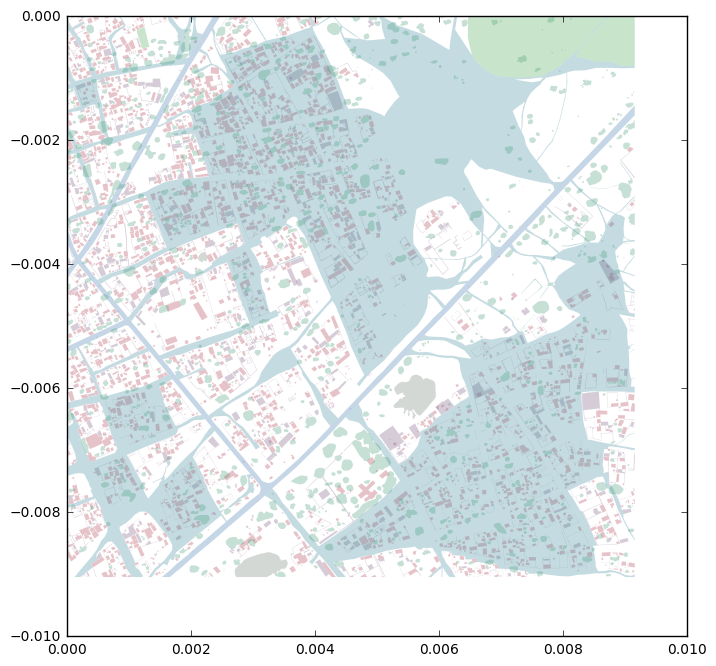

In [23]:
# plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# plotting, color by class type
for p in polygonsList:
    for polygon in polygonsList[p]:
        mpl_poly = Polygon(np.array(polygon.exterior), color=plt.cm.Set1(p*10), lw=0, alpha=0.3)
        ax.add_patch(mpl_poly)

ax.relim()
ax.autoscale_view()

In [24]:
# number of objects on the image by type
'''
1. Buildings
2. Misc. Manmade structures 
3. Road 
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway 
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike
'''
for p in polygonsList:
    print("Type: {:4d}, objects: {}".format(p,len(polygonsList[p].geoms)))

Type:    1, objects: 2208
Type:    2, objects: 1578
Type:    3, objects: 1
Type:    4, objects: 11
Type:    5, objects: 823
Type:    6, objects: 3
Type:    7, objects: 0
Type:    8, objects: 4
Type:    9, objects: 11
Type:   10, objects: 129


In [25]:
df.ImageId.unique()

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3'], dtype=object)

In [27]:
# convert to shapely, get geometries and pivot
df['polygons'] = df.apply(lambda row: wkt.loads(row.MultipolygonWKT),axis=1)
df['nPolygons'] = df.apply(lambda row: len(row['polygons'].geoms),axis=1)

pvt = df.pivot(index='ImageId', columns='ClassType', values='nPolygons')
pvt

ClassType    1     2   3   4     5   6   7   8   9    10
ImageId                                                 
6010_4_2      0     0   0   6  2262   0   0   0   0    0
6010_4_4      0     0   0   0  3860   0   0   0   0    0
6040_1_0      0     0   0   5  2446   0   0   0   0    0
6040_1_3      0     0   0   1  3982   2   0   0   0    0
6040_2_2      0     0   0   2  3879   0   0   0   0    0
6060_2_3     62   173   0   7  1613  86   0   0   0    1
6070_2_3    109    81   2   0    41   0  24   3   0   13
6090_2_0      0    11   0   3  2308   7   0  19   0    1
6100_1_3   2208  1578   1  11   823   3   0   4  11  129
6100_2_3   1690  1224   2  24   574   0   0   2  14  126
6110_1_2   1584  1420   1  10   855  28   0  63   0   23
6110_3_1    581   706   1  19  1239  35   0   9   3   25
6110_4_0    437   502   2  11  1406  29   0  24   7   13
6120_2_0    573  1191   1   4  1542  67   0   0   6   11
6120_2_2   1962  3199   1  32  1452  20   0   6   9  548
6140_1_2   1607  1110   1   8   817  27   0  75   0   23
6140_3_1    565   555   1  19  1110  37   0   9   3   46
6150_2_3      0    47   0   4  2060  68   0   0   0    0
6160_2_1      0     0   0   8  2432   0   0   0   0    0
6170_0_4      0     1   0   9  2774   0   0   8   0    0
6170_2_4      0     1   0   4  2115   2   0   1   0    0
6170_4_1      0     0   0   2  4245   0   0   0   0    0

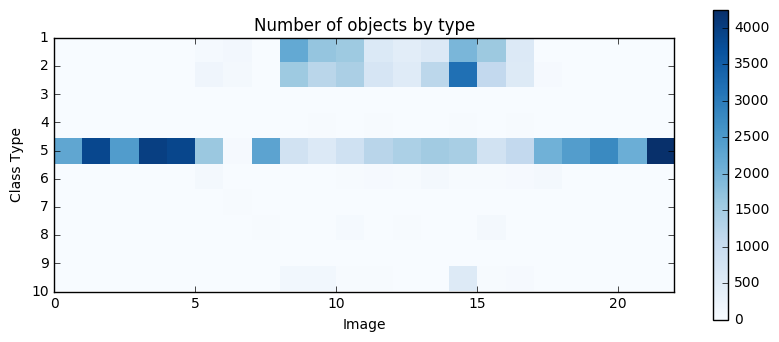

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_aspect('equal')
plt.imshow(pvt.T, interpolation='nearest', cmap=plt.cm.Blues, extent=[0,22,10,1])
plt.yticks(np.arange(1, 11, 1.0))
plt.title('Number of objects by type')
plt.ylabel('Class Type')
plt.xlabel('Image')
plt.colorbar()
plt.show()

In [29]:
from scipy.stats import pearsonr
print("Trees vs Buildings: {:5.4f}".format(pearsonr(pvt[1],pvt[5])[0]))
print("Trees vs Buildings and Structures: {:5.4f}".format(pearsonr(pvt[1]+pvt[2],pvt[5])[0]))

Trees vs Buildings: -0.6076
Trees vs Buildings and Structures: -0.5747


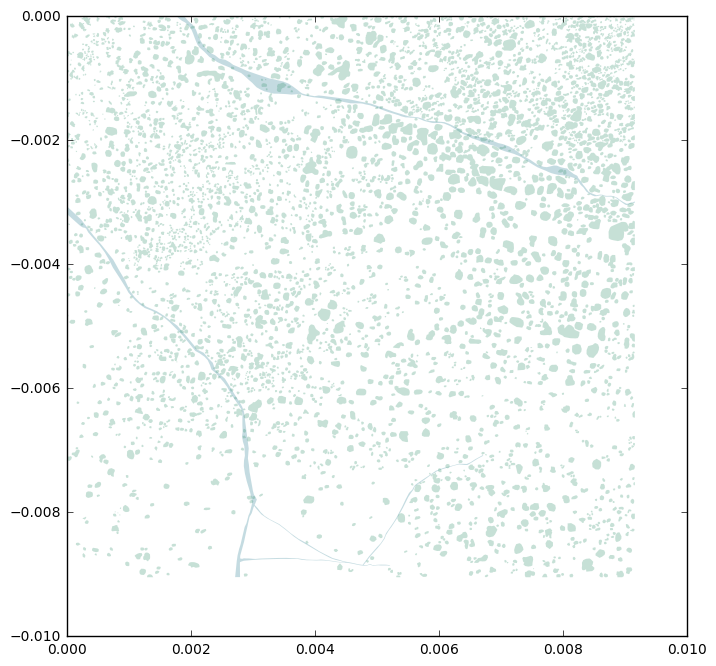

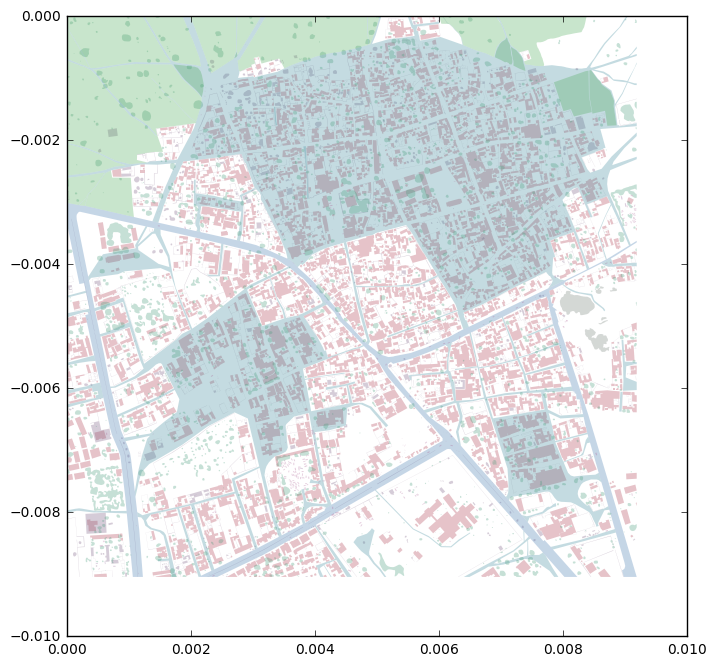

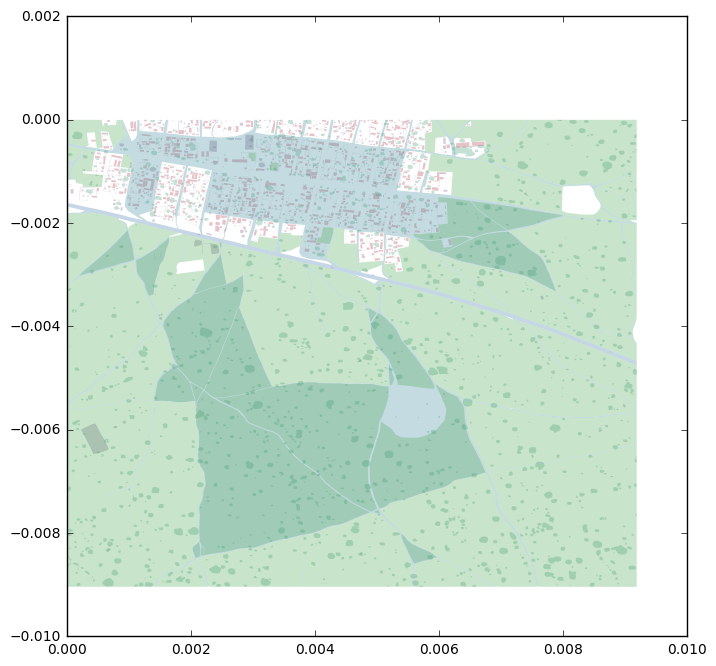

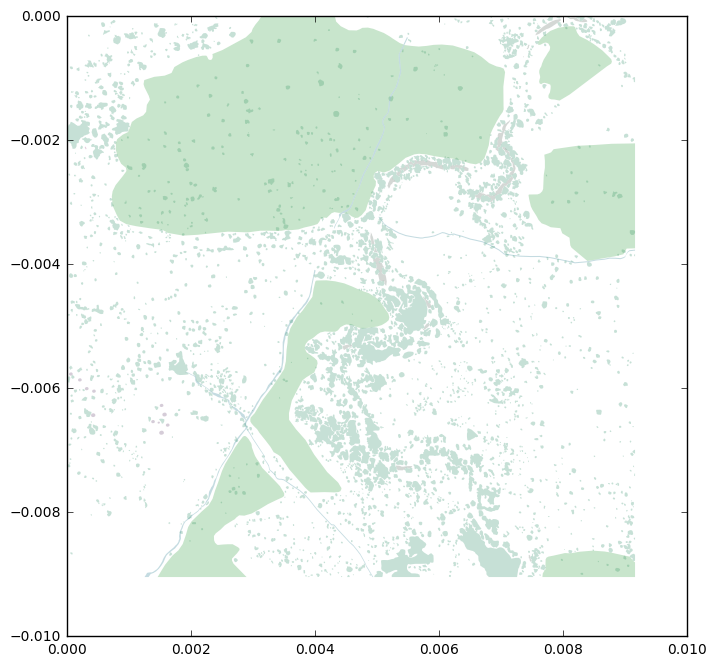

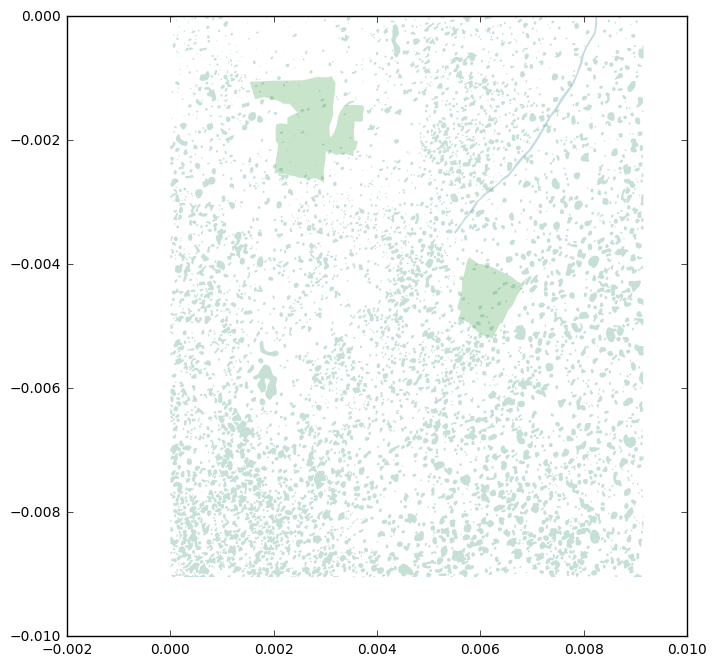

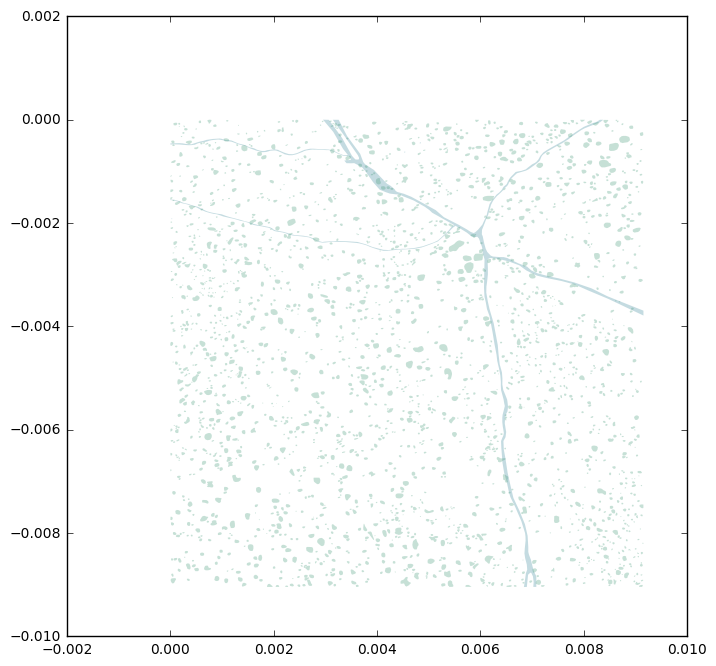

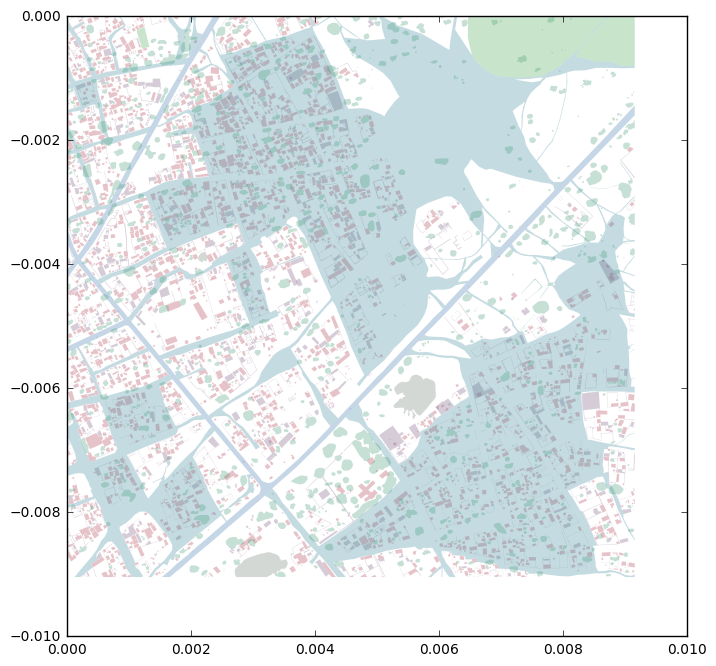

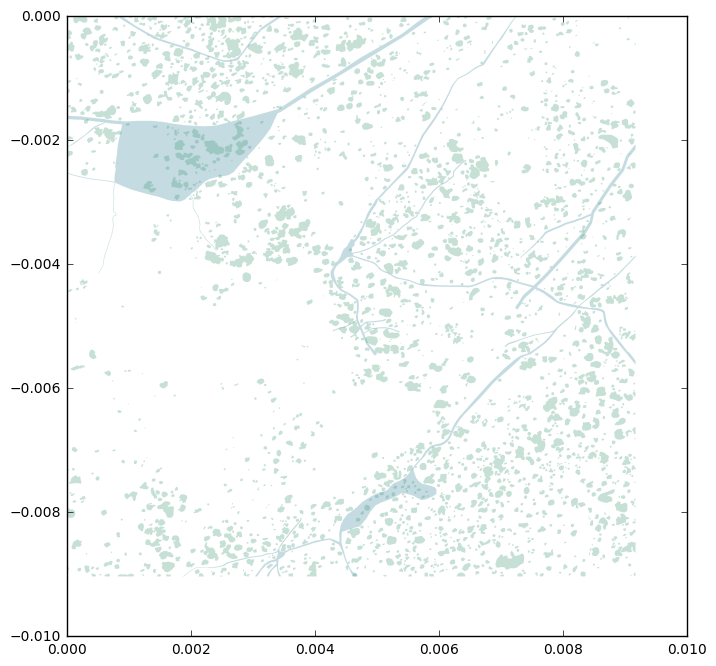

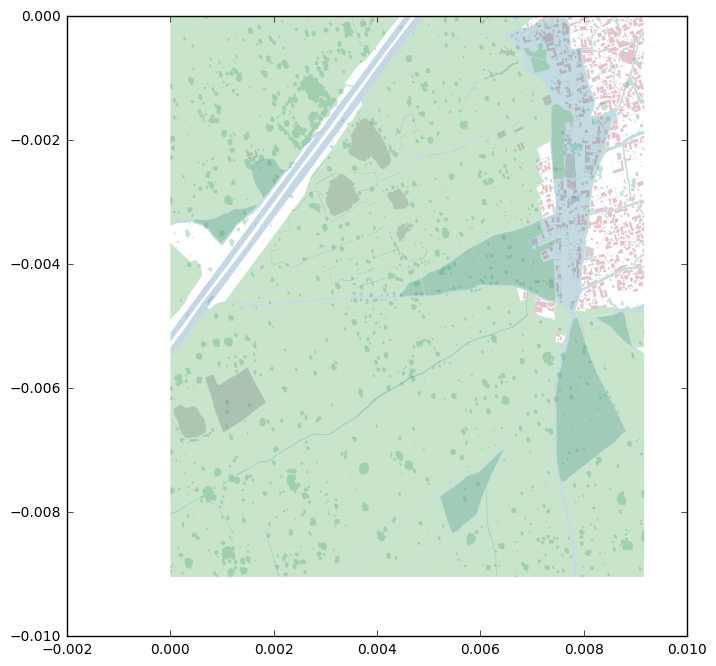

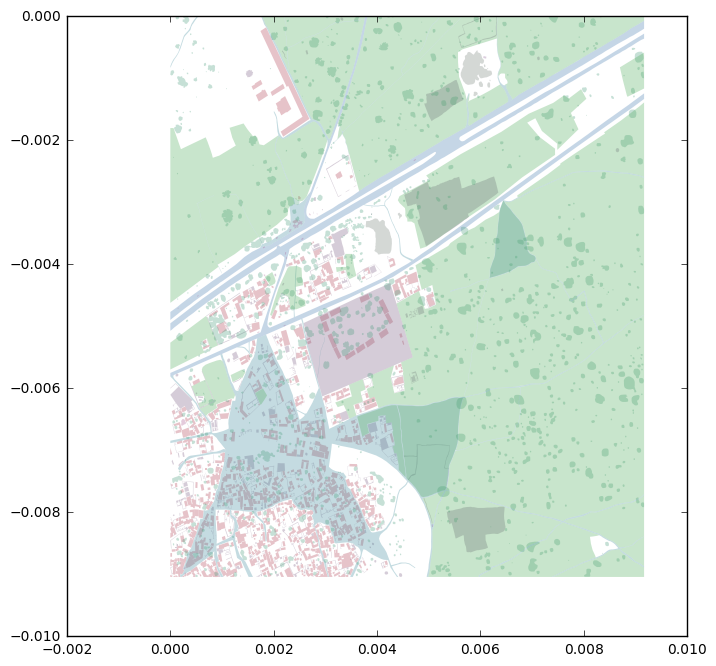

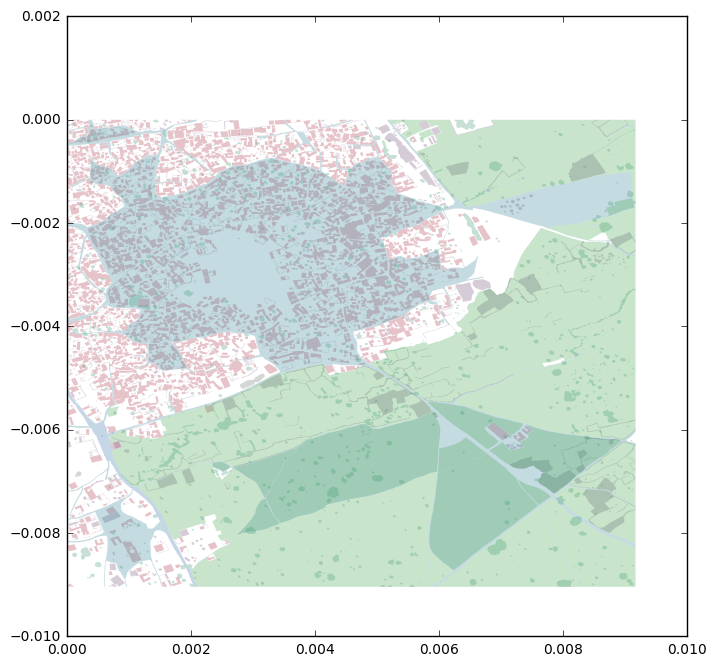

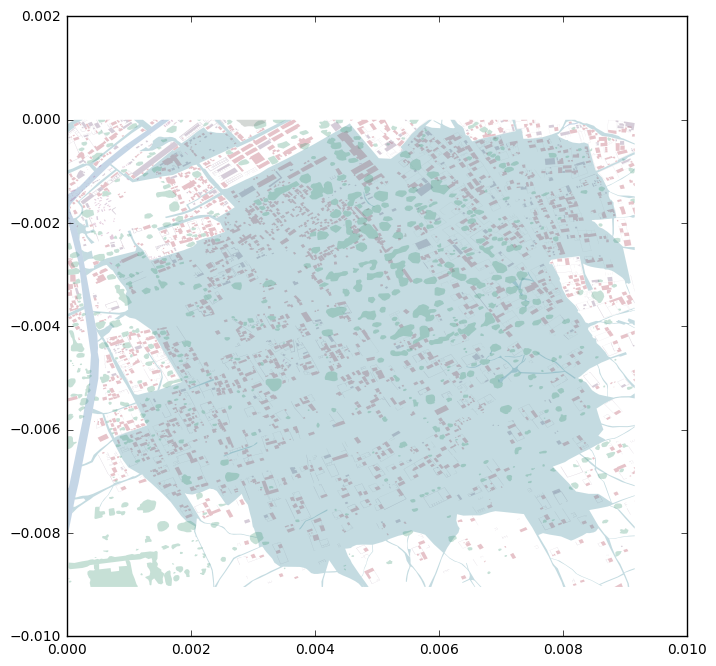

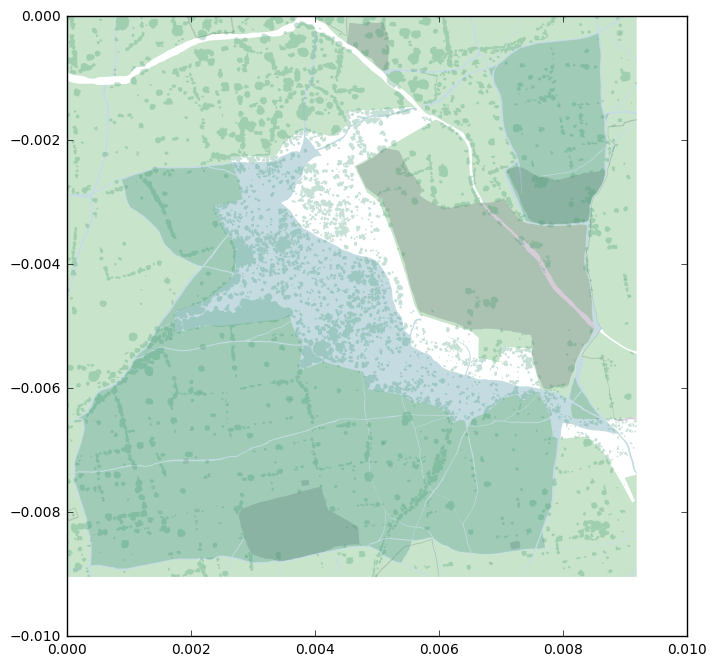

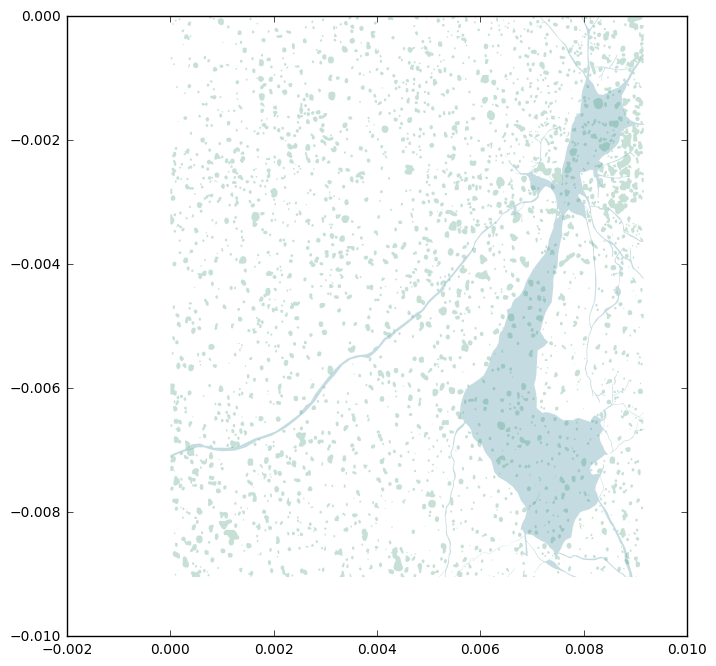

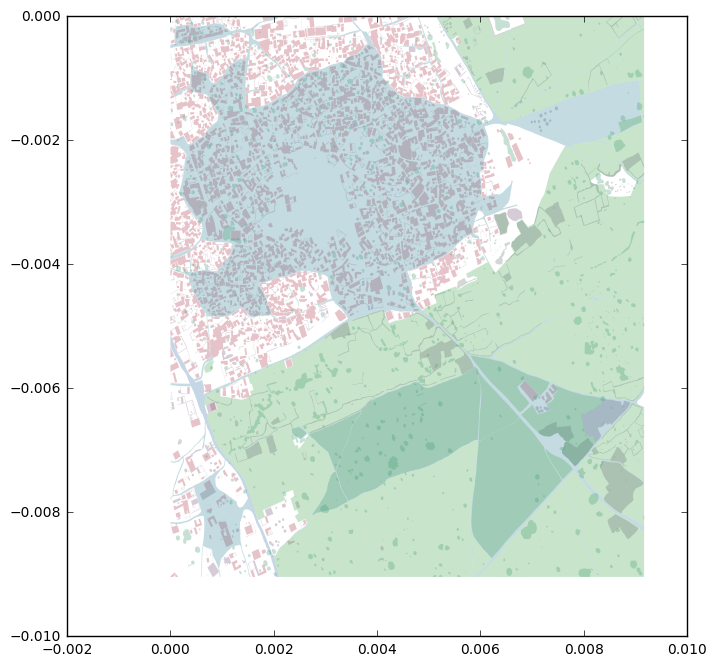

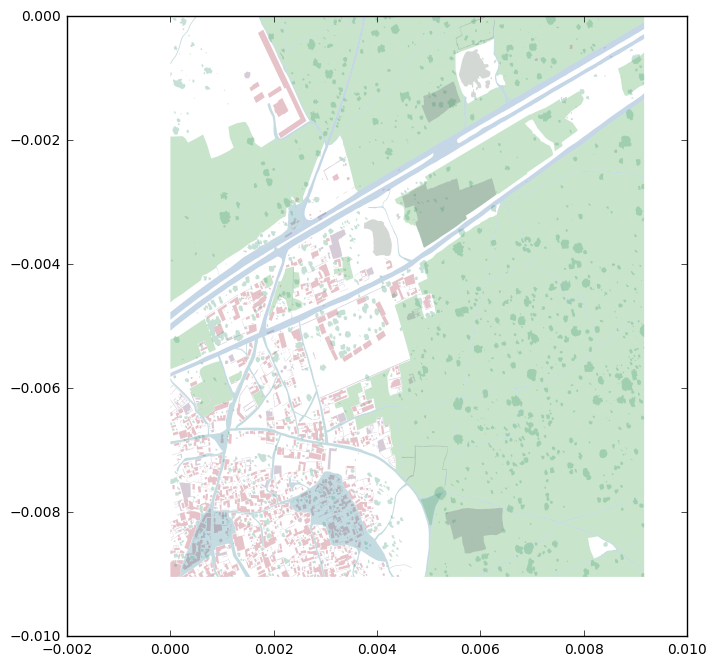

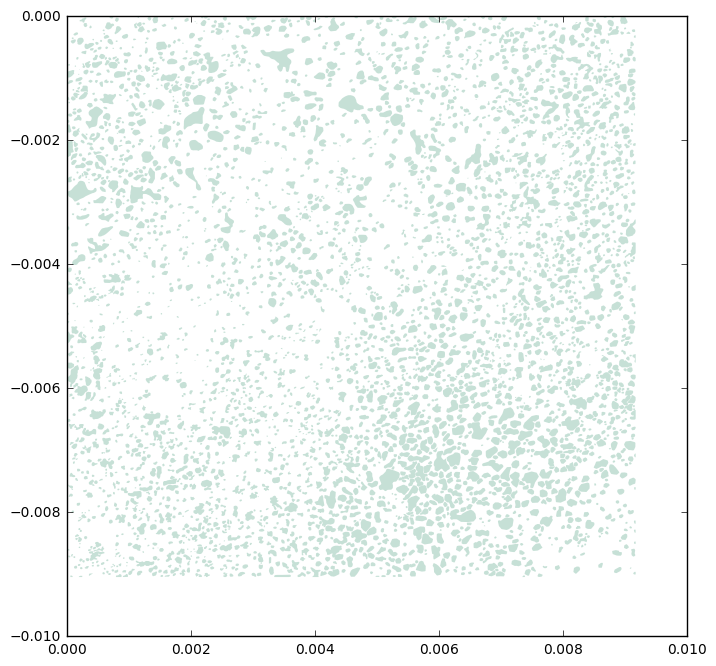

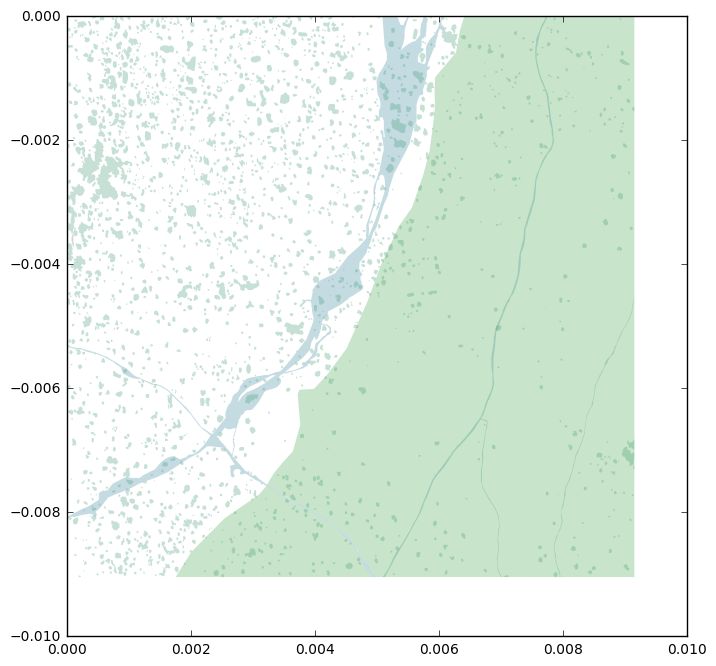

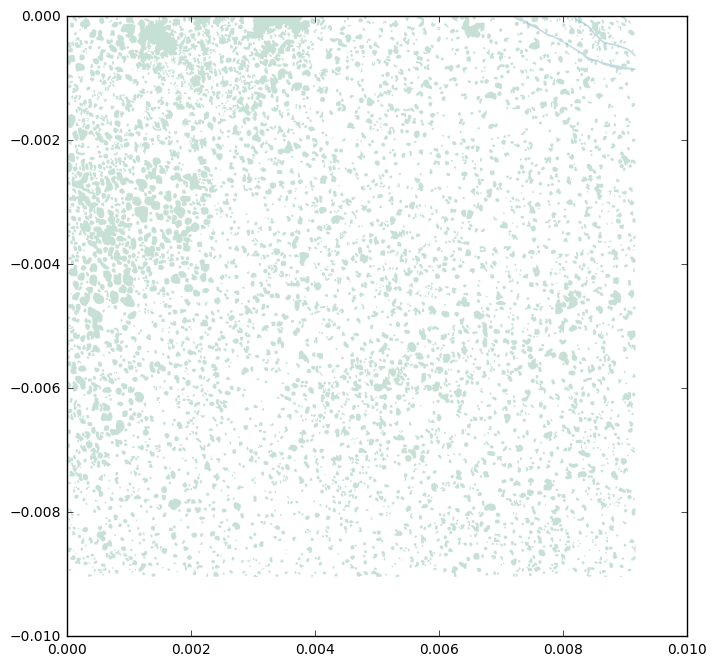

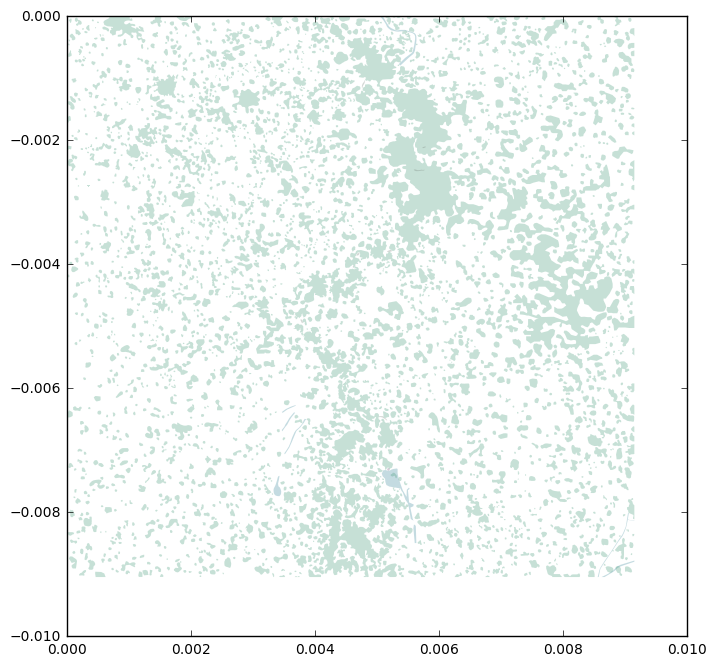

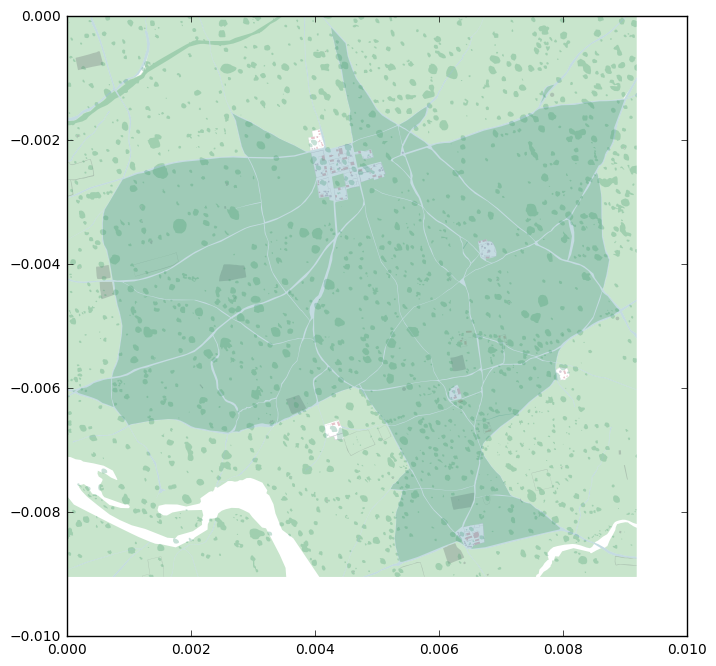

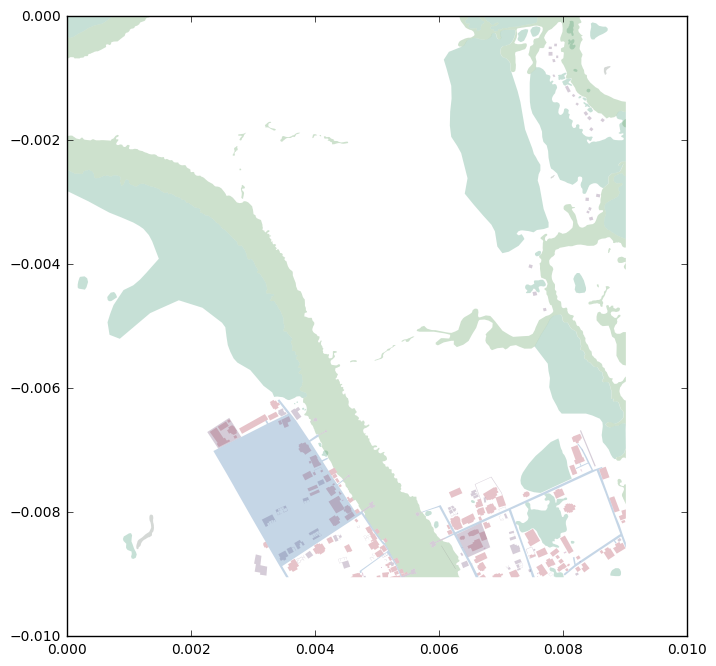

In [31]:
for im in df.ImageId.unique():
    image = df[df.ImageId == im]
    for cType in image.ClassType.unique():
        polygonsList[cType] = wkt.loads(image[image.ClassType == cType].MultipolygonWKT.values[0])
    
    # plot using matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))

    # plotting, color by class type
    for p in polygonsList:
        for polygon in polygonsList[p]:
            mpl_poly = Polygon(np.array(polygon.exterior), color=plt.cm.Set1(p*10), lw=0, alpha=0.3)
            ax.add_patch(mpl_poly)

    ax.relim()
    ax.autoscale_view()
    plt.show()


/Users/kanna/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


(<matplotlib.figure.Figure at 0x1219385c0>,
 <matplotlib.image.AxesImage at 0x1220acb00>)

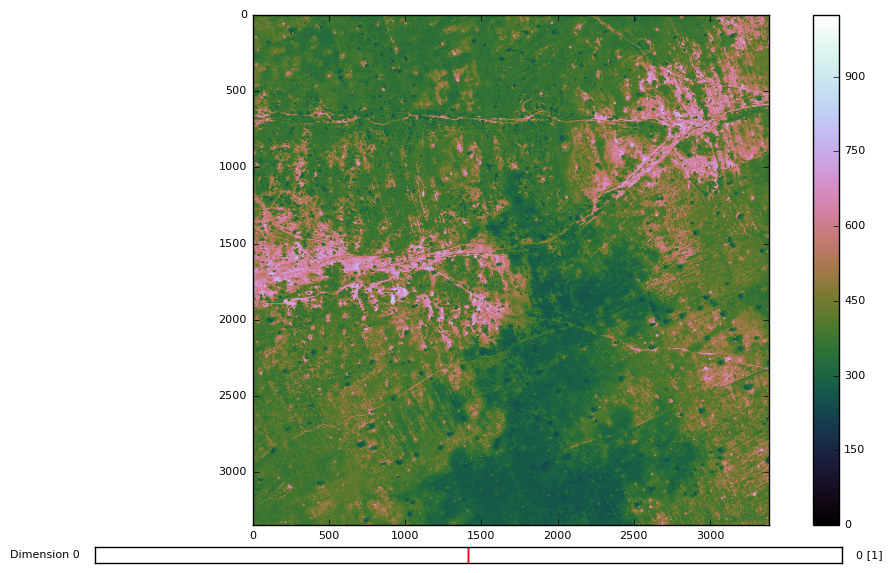

In [34]:
P = tiff.imread('sixteen_band/6100_1_0_P.tif') 
tiff.imshow(P)

(<matplotlib.figure.Figure at 0x12672ff98>,
 <matplotlib.image.AxesImage at 0x11fb31668>)

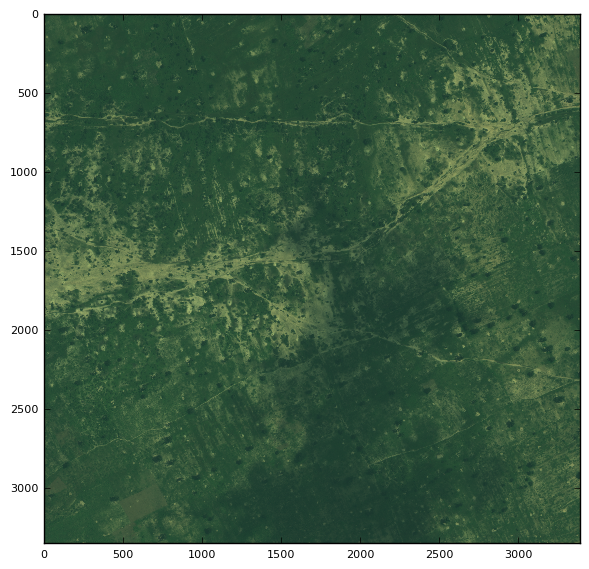

In [35]:
P = tiff.imread('three_band/6100_1_0.tif') 
tiff.imshow(P)